In [18]:
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import re

myStopWords=set(stopwords.words('italian')
                +stopwords.words('english')+
                list(['http','abbiat', 'abov', 'anch', 'avess', 'avest', 'avet', 'avev', 'avrebb',
                      'avrest', 'avret', 'avut', 'becaus', 'befor', 'could', 'doe', 'dure', 'ebb',
                      'erav', 'facciat', 'facess', 'facest', 'facev', 'farebb', 'farest', 'faret',
                      'foss', 'fost', 'might', 'must', 'need', 'nostr', 'onc', 'onli', 'ourselv',
                      'qual', 'quant', 'quell', 'quest', 'sarebb', 'sarest', 'saret', 'siat',
                      'siet', 'starebb', 'starest', 'staret', 'stavat', 'stess', 'stest', 'stett',
                      'stiat', 'themselv', 'thi', 'veri', 'vostr', 'would', 'yourselv','becau','http']))

def replace_urls(in_string, replacement=None):
   
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)


def tokenize_and_stem(doc):
    
    #split into words
    tokens = word_tokenize(doc)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # remove words shorter than 4 char
    tokens = [word for word in tokens if len(word)>3]
    # handle URLS
    tokens = [replace_urls(w) for w in tokens]
    
    # stemming of words
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]

    return tokens

In [2]:
from pymongo import MongoClient
import gensim 
import pandas as pd  
import numpy as np 


client = MongoClient('localhost', 27017)
db = client['TweetFULLTorini']

tweets = pd.DataFrame(list(db['FinalCLEAN'].find()))

data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['text']
data['Id'] = tweets['_id']
data['len']  = np.array([len(tweet) for tweet in data['Tweets']])
user = list()
for i in range(0,len(tweets)):
    user.append(tweets['user'][i]['name'])
data['user'] = np.array(user)

In [27]:
docs = data['Tweets']

documents = [tokenize_and_stem(s) for s in docs]

for doc in documents:
    for term in doc:
        if term in myStopWords :
            doc.remove(term)

Topic Modeling is primarily concerned with identifying ‘topics’ (in this sense, a pattern of co-occurring words; ultimately, a topic is a distribution over a given vocabulary) in a corpus (= set of documents).

For the LDA model, we need a document-term matrix (a gensim dictionary) and all articles in vectorized format (we will be using a bag-of-words approach - constructing a vector representation of an article 'doc2bow(text)' )

In [28]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(documents)
#dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference
print(dictionary)

Dictionary(40734 unique tokens: ['ciao', 'dopo', 'fort', 'inizieremo', 'mister']...)


A corpus of all Tweet is constructed and vectorized

In [29]:
corpus = [dictionary.doc2bow(text) for text in documents]
# corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)
# print(corpus)

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

In [30]:
total_topics = 5
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics, passes=100)

In [31]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.021*"http" + 0.009*"circuit" + 0.007*"live" + 0.005*"practic" + 0.005*"thank"'),
 (1,
  '0.008*"robertavinci" + 0.006*"flaviapennetta" + 0.005*"fabiofogna" + 0.005*"follow" + 0.004*"part"'),
 (2,
  '0.019*"asroma" + 0.012*"roma" + 0.007*"officialasroma" + 0.007*"oggi" + 0.006*"grand"'),
 (3,
  '0.016*"grazi" + 0.014*"iamcallo" + 0.008*"circuit" + 0.008*"love" + 0.006*"leicaambassador"'),
 (4,
  '0.010*"http" + 0.006*"prove" + 0.006*"italia" + 0.005*"quando" + 0.005*"oggi"')]

In [32]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [33]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(118, 5)
(5, 118)


In [34]:
df_lda

,amor,ancora,anni,asroma,auguri,back,bene,best,bologna,buon,...,ufficiali,unfollow,venerdì,video,vieribobo,vittoria,voglio,work,world,zaniolo
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002628,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002227,0.000000,0.000000,0.0000,0.002248,0.002718,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.004177,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003872,0.000000,0.000000,0.000000,0.003596,0.0000,0.000000,0.000000,0.000000
2,0.000000,0.003256,0.000000,0.019246,0.005902,0.000000,0.000000,0.000000,0.000000,0.005257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.003673
3,0.003364,0.000000,0.000000,0.000000,0.000000,0.000000,0.004117,0.000000,0.000000,0.000000,...,0.003317,0.000000,0.000000,0.000000,0.000000,0.000000,0.0028,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.003468,0.000000,0.000000,0.000000,0.000000,0.000000,0.002667,0.000000,...,0.000000,0.000000,0.003689,0.000000,0.004108,0.000000,0.0000,0.000000,0.000000,0.000000


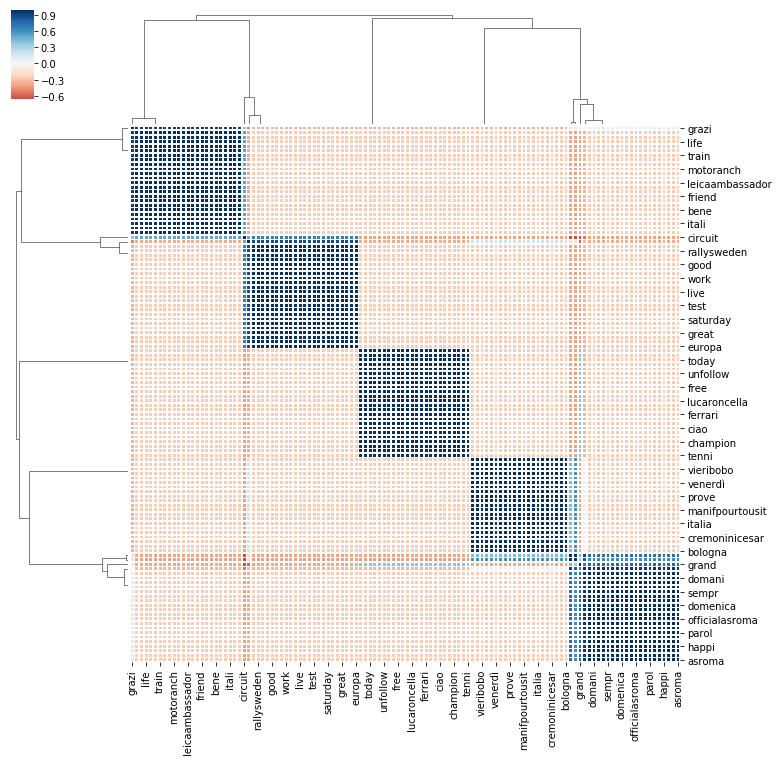

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis